In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install datasets
!pip install ml_things
!pip install pytorch-lightning
!pip install wandb
!python -m pip uninstall matplotlib --y
!pip install matplotlib==3.1.3

In [ ]:
import wandb

wandb.init(project="CS505-DistilGPT2-2-spanish", entity="sks99")

TrainLoss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▁▂▂▂▂▃▁▁▂▂▂▁
TrainLoss,2.78795


In [ ]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          MT5Config,
                          AutoConfig,
                          AutoTokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          AutoModelForSequenceClassification,
                          AutoModel,
                          MT5ForConditionalGeneration)

# Set seed for reproducibility.
set_seed(123)

# Number of training epochs (authors on fine-tuning Bert recommend between 2 and 4).
epochs = 10

batch_size = 32

max_length = 160

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name_or_path = 'distilgpt2'

n_labels = 26

In [ ]:
def read_from_file(filename):
    file = open(filename,"r")
    vocab = file.read().splitlines()
    return vocab

In [ ]:
def save(model, path):
    # save
    torch.save(model.state_dict(), path)

In [ ]:
class TwitterEmojiPrediction(Dataset):
  r"""PyTorch Dataset class for loading data.

  This is where the data parsing happens.

  This class is built with reusability in mind: it can be used as is as.

  Arguments:

    path (:obj:`str`):
        Path to the data partition.

  """

  def __init__(self, data_path, label_path, use_tokenizer):

    self.texts = read_from_file(data_path)
    labels = read_from_file(label_path)
    self.labels = [int(label) for label in labels]
    self.n_examples = len(self.labels)
    

    return

  def __len__(self):
    r"""When used `len` return the number of examples.

    """
    
    return self.n_examples

  def __getitem__(self, item):
    r"""Given an index return an example from the position.
    
    Arguments:

      item (:obj:`int`):
          Index position to pick an example to return.

    Returns:
      :obj:`Dict[str, str]`: Dictionary of inputs that contain text and 
      asociated labels.

    """

    return {'text':self.texts[item],
            'label':self.labels[item]}



class ClassificationCollator(object):
    r"""
    Data Collator used for GPT2 in a classificaiton rask. 
    
    It uses a given tokenizer and label encoder to convert any text and labels to numbers that 
    can go straight into a GPT2 model.

    This class is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

    Arguments:

      use_tokenizer (:obj:`transformers.tokenization_?`):
          Transformer type tokenizer used to process raw text into numbers.

      labels_ids (:obj:`dict`):
          Dictionary to encode any labels names into numbers. Keys map to 
          labels names and Values map to number associated to those labels.

      max_sequence_len (:obj:`int`, `optional`)
          Value to indicate the maximum desired sequence to truncate or pad text
          sequences. If no value is passed it will used maximum sequence size
          supported by the tokenizer and model.

    """

    def __init__(self, use_tokenizer, max_sequence_len=None):

        # Tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len

        return

    def __call__(self, sequences):
        r"""
        This function allowes the class objesct to be used as a function call.
        Sine the PyTorch DataLoader needs a collator function, I can use this 
        class as a function.

        Arguments:

          item (:obj:`list`):
              List of texts and labels.

        Returns:
          :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
          It holddes the statement `model(**Returned Dictionary)`.
        """

        # Get all texts from sequences list.
        texts = [sequence['text'] for sequence in sequences]
        # Get all labels from sequences list.
        labels = [sequence['label'] for sequence in sequences]
        # Encode all labels using label encoder.
        # Call tokenizer on all texts to convert into tensors of numbers with 
        # appropriate padding.
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        # Update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})

        return inputs


def train(dataloader, optimizer_, scheduler_, device_):
  r"""
  Train pytorch model on a single pass through the data loader.

  It will use the global variable `model` which is the transformer model 
  loaded on `_device` that we want to train on.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.

      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.

      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss].
  """

  # Use global variable for model.
  global model

  # Tracking variables.
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch.
  total_loss = 0

  # Put the model into training mode.
  model.train()

  # For each batch of training data...
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()
    
    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    
    # Always clear any previously calculated gradients before performing a
    # backward pass.
    model.zero_grad()

    outputs = model(**batch)

    loss, logits = outputs[:2]

    total_loss += loss.item()
    wandb.log({"TrainLoss" : loss})

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer_.step()

    # Update the learning rate.
    scheduler_.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted labels values.
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data.
  save(model, '/content/drive/MyDrive/505/Project Data/DistilGPT2/model/DistilGPT2_spanish.cpkt')

  avg_epoch_loss = total_loss / len(dataloader)
  
  # Return all true labels and prediction for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
  r"""Validation function to evaluate model performance on a 
  separate set of data.

  This function will return the true and predicted labels so we can use later
  to evaluate the model's performance.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:
    
    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]
  """

  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch.
  total_loss = 0

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        outputs = model(**batch)

        loss, logits = outputs[:2]
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        total_loss += loss.item()

        # wandb.log({"ValidLoss" : loss})
        
        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

## **Load Model and Tokenizer**



In [ ]:
from transformers import AutoModelForCausalLM
# Get model configuration.
print('Loading configuraiton...')
model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
print('Loading model...')
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)
# model = AutoModelForCausalLM("mt5", "google/mt5-small", config=model_config)
# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...


Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Loading tokenizer...


Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Loading model...


Downloading:   0%|          | 0.00/336M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


## **Dataset and Collator**


In [ ]:
import pandas as pd

spanish_train_df = pd.read_csv('/content/drive/MyDrive/505/Project Data/train/spanish/es_modifiedTrainData.csv')
spanish_train_df['Label'] = spanish_train_df['Label'].map(str)
spanish_train_df.head()

,Unnamed: 0,Text,Label
0,0,Es imposible quererte más @ Plaza Del Callao -...,0
1,1,Disfrutando de buena comida con buena compañía...,5
2,2,Muchísimas Felicidades M!!! Nos vemos pronto! ...,8
3,3,Y pensar que a esta persona la conozco de hace...,8
4,4,¡Que buenas son las noches así y que buena com...,25


In [ ]:
spanish_test_df = pd.read_csv('/content/drive/MyDrive/505/Project Data/test/es_modifiedTestData1.csv')
spanish_test_df['Label'] = spanish_test_df['Label'].map(str)
spanish_test_df.head()

,Unnamed: 0,Text,Label
0,0,Buenos días desde Valencia en Comunidad Valenc...,6
1,1,"Anoche en la #prefería con @user ,mi prima eva...",2
2,2,"Porfavor llevarlas a reciclar,necesitamos más ...",2
3,3,El vecino roquero que todos queremos tener en ...,2
4,4,Es un placer contar con profesionales del sect...,0


In [ ]:
def save_to_file(filename, data):
    file = open(filename,"w")
    file.write("\n".join(data))

In [ ]:
save_to_file('/content/drive/MyDrive/505/Project Data/train/spanish/es_train.txt.text', list(spanish_train_df.Text))
save_to_file('/content/drive/MyDrive/505/Project Data/train/spanish/es_train.txt.labels', list(spanish_train_df.Label))

In [ ]:
save_to_file('/content/drive/MyDrive/505/Project Data/test/es_test_modified.txt.text', list(spanish_test_df.Text))
save_to_file('/content/drive/MyDrive/505/Project Data/test/es_test_modified.txt.labels', list(spanish_test_df.Label))

In [ ]:
from torch.utils.data import TensorDataset, random_split
# Create data collator to encode text and labels into numbers.
classificaiton_collator = ClassificationCollator(use_tokenizer=tokenizer,  
                                                          max_sequence_len=max_length)


print('Dealing with Train...')
# Create pytorch dataset.
es_train_data_path = "/content/drive/MyDrive/505/Project Data/train/spanish/es_train.txt.text"
es_train_labels_path = "/content/drive/MyDrive/505/Project Data/train/spanish/es_train.txt.labels"

dataset = TwitterEmojiPrediction(es_train_data_path, es_train_labels_path, 
                               use_tokenizer=tokenizer)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print('Created `train_dataset` with %d examples!'%len(train_dataset))
print('Created `val_dataset` with %d examples!'%len(val_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=classificaiton_collator)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))
print('Created `valid_dataloader` with %d batches!'%len(valid_dataloader))

print()

print('Dealing with Validation...')
# Create pytorch dataset.
test_dataset =  TwitterEmojiPrediction('/content/drive/MyDrive/505/Project Data/test/es_test_modified.txt.text', 
                                        '/content/drive/MyDrive/505/Project Data/test/es_test_modified.txt.labels',
                               use_tokenizer=tokenizer)
print('Created `test_dataset` with %d examples!'%len(test_dataset))

# Move pytorch dataset into dataloader.
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=classificaiton_collator)
print('Created `test_dataloader` with %d batches!'%len(test_dataloader))

Dealing with Train...
Created `train_dataset` with 73048 examples!
Created `val_dataset` with 8117 examples!
Created `train_dataloader` with 2283 batches!
Created `valid_dataloader` with 254 batches!

Dealing with Validation...
Created `test_dataset` with 10000 examples!
Created `test_dataloader` with 313 batches!


## **Train**



Epoch


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/10 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/2283 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/254 [00:00<?, ?it/s]

  train_loss: 2.52300 - val_loss: 2.39035 - train_acc: 0.23222 - valid_acc: 0.26377


Training on batches...


  0%|          | 0/2283 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/254 [00:00<?, ?it/s]

  train_loss: 2.36681 - val_loss: 2.32555 - train_acc: 0.27134 - valid_acc: 0.28594


Training on batches...


  0%|          | 0/2283 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/254 [00:00<?, ?it/s]

  train_loss: 2.30244 - val_loss: 2.30780 - train_acc: 0.29249 - valid_acc: 0.28619


Training on batches...


  0%|          | 0/2283 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/254 [00:00<?, ?it/s]

  train_loss: 2.25447 - val_loss: 2.30064 - train_acc: 0.30793 - valid_acc: 0.28989


Training on batches...


  0%|          | 0/2283 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/254 [00:00<?, ?it/s]

  train_loss: 2.21473 - val_loss: 2.30337 - train_acc: 0.31676 - valid_acc: 0.29777


Training on batches...


  0%|          | 0/2283 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/254 [00:00<?, ?it/s]

  train_loss: 2.18120 - val_loss: 2.31196 - train_acc: 0.32647 - valid_acc: 0.29826


Training on batches...


  0%|          | 0/2283 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/254 [00:00<?, ?it/s]

  train_loss: 2.14582 - val_loss: 2.30219 - train_acc: 0.33707 - valid_acc: 0.29851


Training on batches...


  0%|          | 0/2283 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/254 [00:00<?, ?it/s]

  train_loss: 2.12019 - val_loss: 2.32099 - train_acc: 0.34551 - valid_acc: 0.29962


Training on batches...


  0%|          | 0/2283 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/254 [00:00<?, ?it/s]

  train_loss: 2.09459 - val_loss: 2.33018 - train_acc: 0.35119 - valid_acc: 0.29863


Training on batches...


  0%|          | 0/2283 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/254 [00:00<?, ?it/s]

  train_loss: 2.07937 - val_loss: 2.33398 - train_acc: 0.35620 - valid_acc: 0.29715



/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


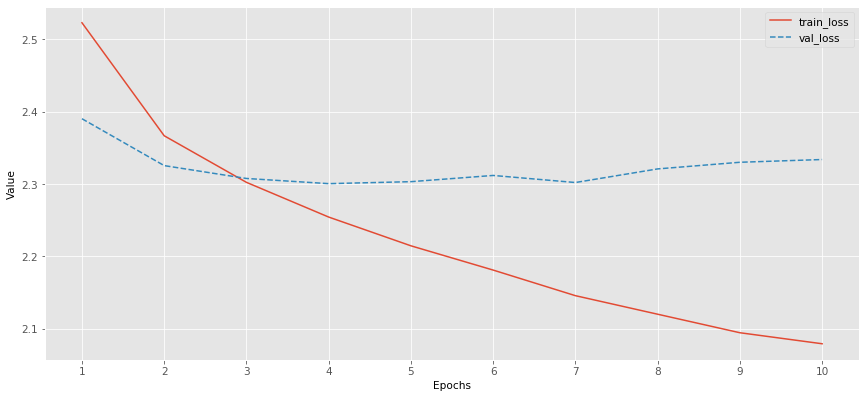

/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


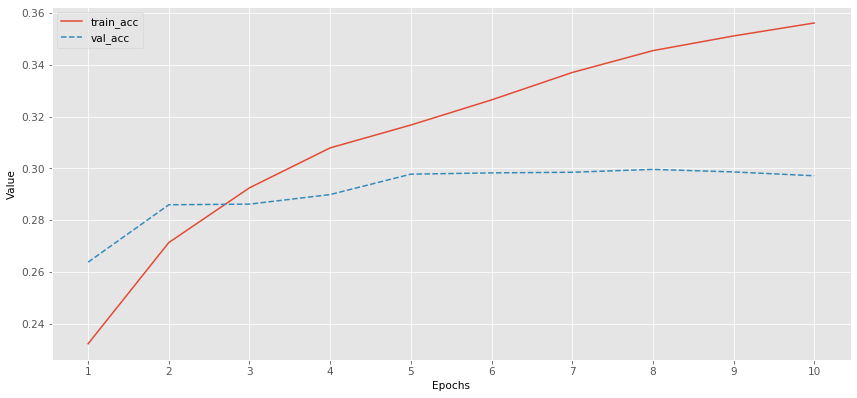

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 3e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  # Get prediction form model on validation data. 
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  wandb.log({"train_acc" : train_acc})
  wandb.log({"train_loss" : train_loss})
  wandb.log({"val_acc" : val_acc})
  wandb.log({"val_loss" : val_loss})

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

## **Evaluate**

When dealing with classification is useful to look at precision recall and F1 score.

A good gauge to have when evaluating a model is the confusion matrix.

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/505/Project Data/DistilGPT2/model/DistilGPT2_spanish.cpkt"))

<All keys matched successfully>

In [ ]:
# Get prediction form model on validation data. This is where you should use
# your test data.
true_labels, predictions_labels, avg_epoch_loss = validation(test_dataloader, device)

emoji_list_sp = ['❤', '😍', '😂', '💕', '🔥', '😊', '😎', '✨', '💙', '😘', '📷', '🇺🇸', '☀', '💜', '😉', '💯', '😁', '🎄', '📸', '😜','💪', '👌', '🇪🇸', '💞', '🎶', '💘']

evaluation_report = classification_report(true_labels, predictions_labels, zero_division=1)
# Show the evaluation report.
print(evaluation_report)

  0%|          | 0/313 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.49      0.65      0.56      2141
           1       0.24      0.45      0.32      1408
           2       0.41      0.52      0.46      1499
           3       0.15      0.06      0.09       352
           5       0.12      0.10      0.11       514
           6       0.15      0.04      0.06       339
           7       0.25      0.08      0.12       416
           8       0.20      0.00      0.01       413
           9       0.24      0.19      0.21       397
          13       0.00      0.00      0.00       235
          14       0.08      0.02      0.03       453
          16       0.00      0.00      0.00       209
          19       0.12      0.01      0.01       274
          20       0.24      0.35      0.28       307
          21       0.06      0.06      0.06       180
          22       0.35      0.38      0.37       424
          23       1.00      0.00      0.00        93
          24       0.14    

In [ ]:
val_acc = accuracy_score(true_labels, predictions_labels)
print("Validation accuracy:", val_acc)

Validation accuracy: 0.3342


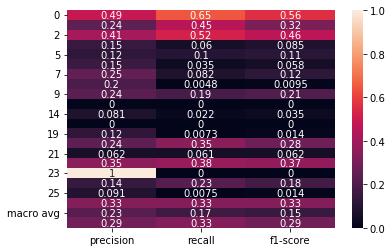

In [ ]:
import pandas as pd
import seaborn as sns
evaluation_report = classification_report(true_labels, predictions_labels, output_dict=True, zero_division=1)
sns.heatmap(pd.DataFrame(evaluation_report).iloc[:-1, :].T, annot=True)

## Top k Accuracy

In [ ]:
def flat_accuracy_topk(preds, labels, topk):
    count = 0
    labels_flat = labels.flatten()
    for i in range(len(preds)):
      logits = preds[i].argsort()[::-1][:topk]
      if labels[i] in logits:
        count += 1
    return count / len(labels_flat)

def validation_topk(model, dataloader, device_, topk):

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch.
  total_loss = 0
  total_eval_accuracy = 0

  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    with torch.no_grad():        

        outputs = model(**batch)
        loss, logits = outputs[:2]
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        total_loss += loss.item()
        label_ids = batch['labels'].to('cpu').numpy()

        total_eval_accuracy += flat_accuracy_topk(logits, label_ids, topk)
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)
  total_acc = total_eval_accuracy /len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss, total_acc

In [ ]:
true_labels, predictions_labels, avg_epoch_loss, top_5_acc = validation_topk(model, test_dataloader, device, 5)
print("Top 5 accuracy:", top_5_acc)

  0%|          | 0/313 [00:00<?, ?it/s]

Top 5 accuracy: 0.6682308306709265


In [ ]:
true_labels, predictions_labels, avg_epoch_loss, top_3_acc = validation_topk(model, test_dataloader, device, 3)
print("Top 3 accuracy:", top_3_acc)

  0%|          | 0/313 [00:00<?, ?it/s]

Top 5 accuracy: 0.547923322683706


## Predicting emotion

In [ ]:
import pandas as pd
def get_emoji_mappings():
  mapping_path = '/content/drive/MyDrive/505/Project Data/mapping/consolidated_mapping.txt'
  emoji_df = pd.read_csv(mapping_path, sep='\t', names=['emoji','emoji_code', 'smt'])

  emoji_label_map = {}
  for emj_idx in range(len(emoji_df['emoji_code'])):
    emoji_label_map[emj_idx] = "<" + emoji_df['emoji_code'][emj_idx] + ">"
  # print(emoji_df)
  return emoji_label_map

In [ ]:
consolidated_mapping = get_emoji_mappings()

In [ ]:
new_mapping = {}
for key, value in consolidated_mapping.items():
  if 'heart' in value:
    new_mapping[value] = 1
  elif 'smiling' in value or 'face' in value:
    new_mapping[value] = 2
  else:
    new_mapping[value] = 3

In [ ]:
true_mapping = []
for label in true_labels:
  if 'heart' in consolidated_mapping[label]:
    true_mapping.append(1)
  elif 'smiling' in consolidated_mapping[label] or 'face' in consolidated_mapping[label]:
    true_mapping.append(2)
  else:
    true_mapping.append(3)

In [ ]:
predictions_mapping = []
for label in predictions_labels:
  if 'heart' in consolidated_mapping[label]:
    predictions_mapping.append(1)
  elif 'smiling' in consolidated_mapping[label] or 'face' in consolidated_mapping[label]:
    predictions_mapping.append(2)
  else:
    predictions_mapping.append(3)

In [ ]:
new_val_acc = accuracy_score(true_mapping, predictions_mapping)
print("Emotion prediction accuracy:", new_val_acc)

Emotion prediction accuracy: 0.596


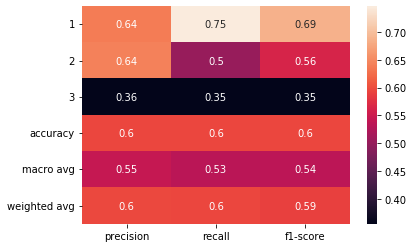

In [ ]:
new_evaluation_report = classification_report(true_mapping, predictions_mapping, output_dict=True, zero_division=1)
sns.heatmap(pd.DataFrame(new_evaluation_report).iloc[:-1, :].T, annot=True)

## Zero shot performance

In [ ]:
zero_shot_dataset =  TwitterEmojiPrediction('/content/drive/MyDrive/505/Project Data/test/us_test.text', 
                                        '/content/drive/MyDrive/505/Project Data/test/us_test.labels',
                               use_tokenizer=tokenizer)
print('Created `zero_shot_dataset` with %d examples!'%len(zero_shot_dataset))

# Move pytorch dataset into dataloader.
zero_shot_dataloader = DataLoader(zero_shot_dataset, batch_size=batch_size, shuffle=False, collate_fn=classificaiton_collator)
print('Created `zero_shot_dataloader` with %d batches!'%len(zero_shot_dataloader))

Created `zero_shot_dataset` with 50000 examples!
Created `zero_shot_dataloader` with 1563 batches!


In [ ]:
zero_shot_true_labels, zero_shot_predictions_labels, zero_shot_avg_epoch_loss = validation(zero_shot_dataloader, device)

emoji_list_sp = ['❤', '😍', '😂', '💕', '🔥', '😊', '😎', '✨', '💙', '😘', '📷', '🇺🇸', '☀', '💜', '😉', '💯', '😁', '🎄', '📸', '😜','💪', '👌', '🇪🇸', '💞', '🎶', '💘']

zero_shot_evaluation_report = classification_report(zero_shot_true_labels, zero_shot_predictions_labels, zero_division=1, target_names=emoji_list_sp)
# Show the evaluation report.
print(zero_shot_evaluation_report)

  0%|          | 0/1563 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           ❤       0.44      0.79      0.57     10798
           😍       0.16      0.26      0.20      4830
           😂       0.23      0.24      0.24      4534
           💕       0.11      0.05      0.07      2605
           🔥       1.00      0.00      0.00      3716
           😊       0.06      0.11      0.08      1613
           😎       0.10      0.07      0.08      1996
           ✨       0.13      0.15      0.14      2749
           💙       0.07      0.01      0.02      1549
           😘       0.06      0.01      0.02      1175
           📷       1.00      0.00      0.00      1432
          🇺🇸       1.00      0.00      0.00      1949
           ☀       1.00      0.00      0.00      1265
           💜       0.04      0.00      0.00      1114
           😉       0.06      0.01      0.02      1306
           💯       1.00      0.00      0.00      1244
           😁       0.02      0.00      0.00      1153
           🎄       1.00    

### Zero shot top 5 accuracy

In [ ]:
zero_shot_true_labels, zero_shot_predictions_labels, zero_shot_avg_epoch_loss, zero_shot_top_5_acc = validation_topk(model, zero_shot_dataloader, device, 5)
print("Top 5 accuracy:", zero_shot_top_5_acc)

  0%|          | 0/1563 [00:00<?, ?it/s]

Top 5 accuracy: 0.45533429302623163


In [ ]:
zero_shot_true_labels, zero_shot_predictions_labels, zero_shot_avg_epoch_loss, zero_shot_top_3_acc = validation_topk(model, zero_shot_dataloader, device, 3)
print("Top 3 accuracy:", zero_shot_top_3_acc)

  0%|          | 0/1563 [00:00<?, ?it/s]

Top 3 accuracy: 0.36824216250799746
